In [1]:
%load_ext autoreload
%autoreload 2

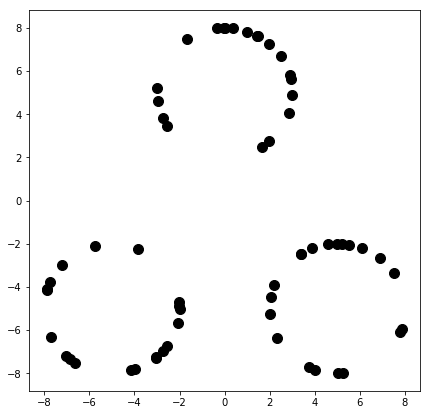

In [3]:
import numpy as np
import numpy.linalg as lin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
import random

d = 2 
n = 20
r = 3

mu1 = np.array( [0,5] )
mu2 = np.array( [-5,-5] )
mu3 = np.array( [5,-5] )

tmp1 = gsd.genSphericalData( d, n, mu1, r )
tmp2 = gsd.genSphericalData( d, n, mu2, r )
tmp3 = gsd.genSphericalData( d, n, mu3, r )
X = np.vstack( (tmp1, tmp2, tmp3) )

fig = pd.getFigure( 7, 7 )
pd.plot2D( X, fig, color = 'k', marker = 'o' )

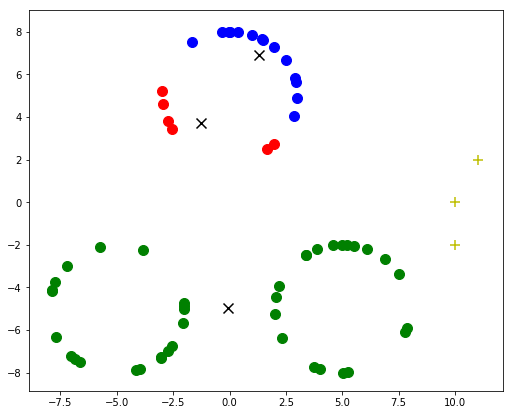

In [4]:
# A fast way to compute all pairs distances using Python's broadcasting techniques
def getAllPairsDistances( A, B ):
    squaredNormsA = np.square( lin.norm( A, axis = 1 ) )
    squaredNormsB = np.square( lin.norm( B, axis = 1 ) )
    return squaredNormsA[:, np.newaxis] + squaredNormsB - 2 * A.dot( B.T )

# For every point, return which is the closest centroid
def getClosestCentroid( X, muVals ):
    return np.argmin( getAllPairsDistances( X, muVals ), axis = 1 )

# Update every centroid to the mean of all data points assigned to that cluster
def updateCentroids( X, z, k, prevMuVals ):
    muVals = np.zeros( (k, X.shape[1]) )
    for i in range( k ):
        if z[z == i].size > 0:
            muVals[i,:] = np.mean( X[z == i,:], axis = 0 )
        # If some cluster is empty, return the old value of its centroid
        else:
            muVals[i,:] = prevMuVals[i,:]
    return muVals

# Execute the Llyod's algorithm
def dokmeans( X, k, init, niter ):
    muVals = init
    # Perform alternating minimization for niter steps
    for t in range( niter ):
        z = getClosestCentroid( X, muVals )
        muVals = updateCentroids( X, z, k, muVals )
    return (muVals, z)

k = 3
# Random initializations are popular for k-means
# init = np.random.normal( 0, 1, (k,d) )
# Adversarial initializations can cause k-means to get stuck in bad assignments
init = np.array( [[10,0], [10,-2], [11,2]] )
# No matter how long we run the algorithm, it does not get unstuck
(muVals, z) = dokmeans( X, 3, init, 1000)

fig2 = pd.getFigure( 8.5, 7 )
pd.plot2D( X[z == 0], fig2, color = 'r', marker = 'o' )
pd.plot2D( X[z == 1], fig2, color = 'g', marker = 'o' )
pd.plot2D( X[z == 2], fig2, color = 'b', marker = 'o' )
pd.plot2D( muVals, fig2, color = 'k', marker = 'x' )
pd.plot2D( init, fig2, color = 'y', marker = '+' )

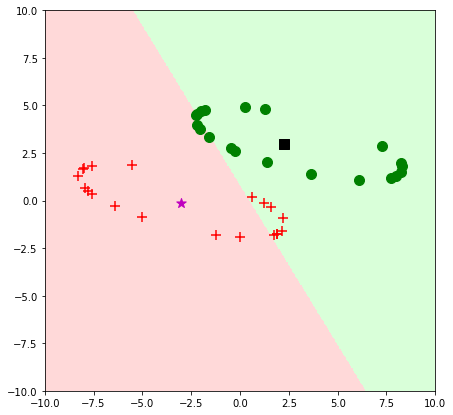

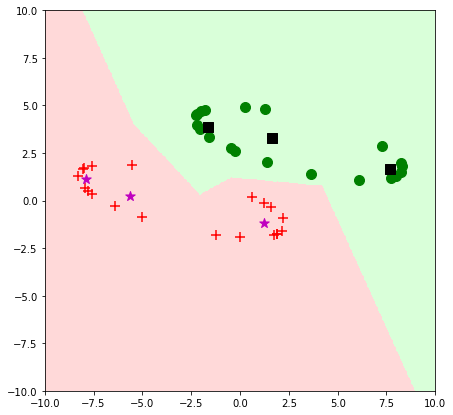

In [5]:
# Refer to lec3.ipynb for details
def LwPBatch( X ):
    return lin.norm( X - protoPos, ord = 2, axis = 1 ) - lin.norm( X - protoNeg, ord = 2, axis = 1 )

# Learn with multiple prototypes per class
def LwMPBatch( X ):
    # Get distances from all positive prototypes
    distPos = getAllPairsDistances( X, muPos )
    # Get distances from all negative prototypes
    distNeg = getAllPairsDistances( X, muNeg )
    # Is the closest positive prototype closer or is the closest negative prototype closer?
    return np.min( distPos, axis = 1 ) - np.min( distNeg, axis = 1 )

# Perform the k-means++ initialization - refer to Arthur and Vassilvitskii, SODA 2007
def doKMPPInit( X, k ):
    init = np.zeros( (k, X.shape[1]) )
    n = X.shape[0]
    # Choose a random data point and make it a centroid
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, k ):
        # For all data points, find the squared Euclidean distance to the closest centroid
        # Python is funny: init[0,:] generates a vector but init[0:1,:] generates a matrix with one row :)
        dist = np.min( getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        # Choose the next centroid to be one that is likely to be far from all currently chosen centroids
        probs = dist/np.sum(dist)
        # Numerical issues in Python may cause ||x-x||_2 to be not exactly zero
        probs[probs < 1e-10] = 0
        i = np.random.choice( np.arange( n ), p = probs )
        init[t,:] = X[i,:]
        
    return init

# Let us generate data where LwP will fail
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )

# Calculate one prototype for each of the two classes
protoPos = np.sum( XPos, 0 )/n
protoNeg = np.sum( XNeg, 0 )/n

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( LwPBatch, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'g', marker = 'o' )
pd.plot2DPoint( protoPos, fig3, color = 'm', marker = '*' )
pd.plot2DPoint( protoNeg, fig3, color = 'k', marker = 's' )

k = 3

# k-means can really struggle with larger values of k if initialized randomly
# initPos = np.random.normal( 0, 1, (k,d) )
# initNeg = np.random.normal( 0, 1, (k,d) )

# k-means offers much better performance if initialized with k-means++
# With k-means++, we may even use extremely large values of k, for example k -> n
# and still get stable solutions. Recall that k = n simply recovers the 1NN algo
# k = n
initPos = doKMPPInit( XPos, k )
initNeg = doKMPPInit( XNeg, k )

(muPos, zPos) = dokmeans( XPos, k, initPos, 10)
(muNeg, zNeg) = dokmeans( XNeg, k, initNeg, 10)

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( LwMPBatch, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )
pd.plot2D( muPos, fig4, color = 'm', marker = '*' )
pd.plot2D( muNeg, fig4, color = 'k', marker = 's' )